In [48]:
import pickle
with open("data/davis_b3/davis_b3_esm_pretrain.pkl", "rb") as f:
    protein_embeddings_full = pickle.load(f)
    
# Extract the actual embedding dictionary
protein_embeddings = protein_embeddings_full["vec_dict"]
print(len(protein_embeddings))

import pandas as pd

# Load protein sequences
pharos_load = pd.read_csv("data/davis_b3/pharos.csv")
davis_load = pd.concat([
    pd.read_csv("data/davis_b3/davis_b3_test_1.csv"),
    pd.read_csv("data/davis_b3/davis_b3_test_2.csv"),
    pd.read_csv("data/davis_b3/davis_b3_test_3.csv"),
    pd.read_csv("data/davis_b3/davis_b3_test_4.csv"),
    pd.read_csv("data/davis_b3/davis_b3_test_5.csv")
], ignore_index=True)

# Get sets of protein IDs
davis_protein_ids = set(davis_load["protein_id"])
pharos_protein_ids = set(pharos_load["protein_id"])

print(len(davis_protein_ids))
print(len(pharos_protein_ids))
# Keep only valid IDs that are actually in the embedding dictionary
davis_protein_embeddings = {pid: protein_embeddings[pid] for pid in davis_protein_ids if pid in protein_embeddings}
pharos_protein_embeddings = {pid: protein_embeddings[pid] for pid in pharos_protein_ids if pid in protein_embeddings}

print(f"{len(davis_protein_embeddings)} DAVIS proteins with embeddings")
print(f"{len(pharos_protein_embeddings)} PHAROS proteins with embeddings")

import pandas as pd

# Get sets of protein IDs
davis_drug_ids = set(davis_load["drug_id"].astype(str))
pharos_drug_ids = set(pharos_load["drug_id"])

print(len(davis_drug_ids))
print(len(pharos_drug_ids))

import pickle
with open("data/davis_b3/davis_b3_mol_pretrain.pkl", "rb") as f:
    drug_embeddings_full = pickle.load(f)
    
# Extract the actual embedding dictionary
drug_embeddings = drug_embeddings_full["vec_dict"]

print(len(drug_embeddings))

# Keep only drug_ids that exist in the embeddings dict
davis_drug_embeddings = {
    did: drug_embeddings[did]
    for did in davis_drug_ids if did in drug_embeddings
}
print(len(davis_drug_embeddings))
pharos_drug_embeddings = {
    did: drug_embeddings[did]
    for did in pharos_drug_ids if did in drug_embeddings
}
print(len(pharos_drug_embeddings))

470
379
28
379 DAVIS proteins with embeddings
28 PHAROS proteins with embeddings
68
209
277
68
209


In [49]:
def compute_continuous_hull_distance(unblinded, blinded_subset):
    from shapely.geometry import Point
    from shapely.ops import nearest_points
    from scipy.spatial import ConvexHull, Delaunay
    import numpy as np
    from shapely.geometry import Polygon

    # === Build hull from unblinded set ===
    hull = ConvexHull(unblinded)
    polygon = Polygon(unblinded[hull.vertices])
    delaunay = Delaunay(unblinded[hull.vertices])

    # === Step 1: Compute max inside distance from unblinded set only ===
    unblinded_dists = []
    for point in unblinded:
        pt = Point(point)
        nearest = nearest_points(pt, polygon.boundary)[1]
        dist = pt.distance(nearest)
        is_inside = delaunay.find_simplex([point])[0] >= 0
        if is_inside:
            unblinded_dists.append(dist)

    max_inside = max(unblinded_dists) if unblinded_dists else 0.0

    # === Step 2: Compute adjusted distances for blinded points ===
    dists = []
    is_inside_list = []

    for point in blinded_subset:
        pt = Point(point)
        nearest = nearest_points(pt, polygon.boundary)[1]
        dist = pt.distance(nearest)
        is_inside = delaunay.find_simplex([point])[0] >= 0
        dists.append(dist)
        is_inside_list.append(is_inside)

    dists = np.array(dists)
    is_inside = np.array(is_inside_list)

    adjusted_dist = dists.copy()
    adjusted_dist[is_inside] = max_inside - dists[is_inside]   # inside: 0 = deepest
    adjusted_dist[~is_inside] = dists[~is_inside] + max_inside  # outside: continues upward

    return adjusted_dist, is_inside



def estimate_sparse_weight(unblinded, blinded_subset, k=20):
    import numpy as np
    from sklearn.neighbors import NearestNeighbors

    # Step 1: Fit k-NN on unblinded
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(unblinded)

    # Step 2: Compute unblinded point densities
    dists_unblinded, _ = nn.kneighbors(unblinded)
    density_unblinded = 1 / (dists_unblinded.mean(axis=1) + 1e-8)
    log_density_unblinded = np.log(density_unblinded + 1e-8)

    # Step 3: Compute blinded point densities
    dists_blinded, _ = nn.kneighbors(blinded_subset)
    density_blinded = 1 / (dists_blinded.mean(axis=1) + 1e-8)
    log_density_blinded = np.log(density_blinded + 1e-8)

    # Step 4: Compute z-score sparsity on log scale (higher = more sparse)
    mu = np.mean(log_density_unblinded)
    sigma = np.std(log_density_unblinded) + 1e-8
    sparsity_z = (mu - log_density_blinded) / sigma

    return sparsity_z


# === Final hybrid ERS computation ===
def compute_ERS_for_points(unblinded, blinded_subset, gamma=5.0, k=5, merged=None, use_cspd=True):
    cspd = None
    continuous_hull_distance, is_inside = compute_continuous_hull_distance(unblinded, blinded_subset)
    # Possibly override with CSPD if requested
    if use_cspd and merged is not None:
        cspd = np.abs((merged["Unblinded_Prediction"] - merged["Blinded_Prediction"]))
        dists_for_ERS = cspd
    else:
        dists_for_ERS = continuous_hull_distance

    # Sparsity
    sparsity_weights = np.maximum(estimate_sparse_weight(unblinded, blinded_subset, k=k), 1e-3) #THINK ABOUT THIS PART MORE

    # ERS
    print(len(dists_for_ERS))
    print(len(sparsity_weights))
    ERS_vals = dists_for_ERS * sparsity_weights
    print(len(ERS_vals))

    return ERS_vals, continuous_hull_distance, sparsity_weights, cspd, is_inside


def compute_model_level_csvs(ERS_vals, is_inside):
    ERS_vals = np.array(ERS_vals)
    is_inside = np.array(is_inside)

    # Boolean masks
    inside_mask = is_inside
    outside_mask = ~is_inside

    # Count totals
    num_total = len(ERS_vals)
    num_inside = inside_mask.sum()
    num_outside = outside_mask.sum()

    # Compute CHR
    CHR = num_outside / num_total if num_total > 0 else 0.0

    # Means (safe fallback to NaN if no points)
    mean_ERS_inside = ERS_vals[inside_mask].mean() if num_inside > 0 else np.nan
    mean_ERS_outside = ERS_vals[outside_mask].mean() if num_outside > 0 else np.nan

    # === Option 1: Weighted Average (original proposal) ===
    CSVS_weighted = (
        (num_inside / num_total) * mean_ERS_inside +
        (num_outside / num_total) * mean_ERS_outside
        if num_total > 0 else np.nan
    )

    # === Option 2: CHR-weighted outside ERS (recommended) ===
    CSVS_chr_scaled = CHR * mean_ERS_outside if mean_ERS_outside is not np.nan else np.nan

    return {
        "CHR": CHR,
        "Mean_ERS_inside": mean_ERS_inside,
        "Mean_ERS_outside": mean_ERS_outside,
        "CSVS_weighted": CSVS_weighted,
        "CSVS_chr_scaled": CSVS_chr_scaled
    }



In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points
from scipy.spatial import Delaunay, ConvexHull
from sklearn.neighbors import NearestNeighbors

# === Load and merge data ===
unblinded_df = pd.read_csv("new/AVG_crossval_predictions.csv")
blinded_df = pd.read_csv("new/concatenated_final_test_predictions.csv")
pharos_df=pd.read_csv("new/AVG_pharos_test_predictions.csv")

unblinded_df = unblinded_df.rename(columns={"Predicted_Value": "Unblinded_Prediction"})
blinded_df = blinded_df.rename(columns={"Predicted_Value": "Blinded_Prediction"})
pharos_df = pharos_df.rename(columns={"Predicted_Value": "Blinded_Prediction"})
blinded_df["Drug_ID"] = blinded_df["Drug_ID"].astype(str)
unblinded_df["Drug_ID"] = unblinded_df["Drug_ID"].astype(str)

merged_df = pd.merge(
    unblinded_df[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction"]],
    blinded_df[["Drug_ID", "Protein_ID", "True_Label", "Blinded_Prediction"]],
    on=["Drug_ID", "Protein_ID", "True_Label"]
)

unblinded = merged_df[["True_Label", "Unblinded_Prediction"]].values
blinded = merged_df[["True_Label", "Blinded_Prediction"]].values
pharos = pharos_df[["True_Label", "Blinded_Prediction"]].values

# === 2. Identify unmatched ===
unblinded_unmatched = pd.merge(
    unblinded_df, merged_df[["Drug_ID", "Protein_ID", "True_Label"]],
    on=["Drug_ID", "Protein_ID", "True_Label"],
    how="left", indicator=True
).query('_merge == "left_only"').drop(columns=["_merge"])

blinded_unmatched = pd.merge(
    blinded_df, merged_df[["Drug_ID", "Protein_ID", "True_Label"]],
    on=["Drug_ID", "Protein_ID", "True_Label"],
    how="left", indicator=True
).query('_merge == "left_only"').drop(columns=["_merge"])

print(f"Unmatched in unblinded: {len(unblinded_unmatched)}")
print(f"Unmatched in blinded: {len(blinded_unmatched)}")

# === 3. Iterative matching by rounding True_Label ===
merged_rounded = pd.DataFrame()

for r in [8,7,6,5,4]:
    print(f"\nTrying merge with True_Label rounded to {r} decimals...")
    u = unblinded_unmatched.copy()
    b = blinded_unmatched.copy()

    u["Rounded_Label"] = u["True_Label"].round(r)
    b["Rounded_Label"] = b["True_Label"].round(r)

    merged = pd.merge(
        u[["Drug_ID", "Protein_ID", "Rounded_Label", "True_Label", "Unblinded_Prediction"]],
        b[["Drug_ID", "Protein_ID", "Rounded_Label", "True_Label", "Blinded_Prediction"]],
        on=["Drug_ID", "Protein_ID", "Rounded_Label"],
        suffixes=("_unblinded", "_blinded"),
        how="inner"
    )

    print(f"Matched {len(merged)} more rows at {r} decimals")
    merged_rounded = pd.concat([merged_rounded, merged], ignore_index=True)

    # Update unmatched
    matched_keys = merged[["Drug_ID", "Protein_ID", "Rounded_Label"]].drop_duplicates()
    unblinded_unmatched = pd.merge(u, matched_keys, on=["Drug_ID", "Protein_ID", "Rounded_Label"], how="left", indicator=True)
    unblinded_unmatched = unblinded_unmatched.query('_merge == "left_only"').drop(columns=["_merge"])

    blinded_unmatched = pd.merge(b, matched_keys, on=["Drug_ID", "Protein_ID", "Rounded_Label"], how="left", indicator=True)
    blinded_unmatched = blinded_unmatched.query('_merge == "left_only"').drop(columns=["_merge"])

# === 4. Combine all matched ===
all_merged = pd.concat([
    merged_df[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction", "Blinded_Prediction"]],
    merged_rounded[["Drug_ID", "Protein_ID", "True_Label_blinded", "Unblinded_Prediction", "Blinded_Prediction"]].rename(columns={"True_Label_blinded": "True_Label"})
], ignore_index=True)

print(f"\n Total merged: {len(all_merged)}")
print(f"Still unmatched in blinded: {len(blinded_unmatched)}")
print(f"Still unmatched in unblinded: {len(unblinded_unmatched)}")

# Save final datasets if desired
all_merged.to_csv("merged_blinded_unblinded_full.csv", index=False)
blinded_unmatched.to_csv("unmatched_blinded_rows.csv", index=False)

# After iterative merge, use all_merged as your gold-standard matched data
unblinded_df = all_merged[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction"]].copy()
blinded_df   = all_merged[["Drug_ID", "Protein_ID", "True_Label", "Blinded_Prediction"]].copy()
merged_df = all_merged

# Redefine your arrays to use only the merged data
unblinded = all_merged[["True_Label", "Unblinded_Prediction"]].values
blinded   = all_merged[["True_Label", "Blinded_Prediction"]].values

# Leave pharos as-is (it's already separate and untouched)
pharos    = pharos_df[["True_Label", "Blinded_Prediction"]].values

print(len(blinded_df))
print(len(unblinded_df))
print(len(blinded))
print(len(unblinded))




_,is_inside = compute_continuous_hull_distance(unblinded, blinded)
blinded_df["Is_Inside"] = is_inside

outside_mask = ~blinded_df["Is_Inside"]
davis_outside_df = blinded_df

Unmatched in unblinded: 9508
Unmatched in blinded: 3697

Trying merge with True_Label rounded to 8 decimals...
Matched 643 more rows at 8 decimals

Trying merge with True_Label rounded to 7 decimals...
Matched 544 more rows at 7 decimals

Trying merge with True_Label rounded to 6 decimals...
Matched 2105 more rows at 6 decimals

Trying merge with True_Label rounded to 5 decimals...
Matched 405 more rows at 5 decimals

Trying merge with True_Label rounded to 4 decimals...
Matched 0 more rows at 4 decimals

 Total merged: 27621
Still unmatched in blinded: 0
Still unmatched in unblinded: 5811
27621
27621
27621
27621


# Protein

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics.pairwise import cosine_similarity

# === Compute similarity of each protein to the training proteins ===
def build_protein_similarity_cache(protein_embeddings, train_proteins, save_path="protein_similarity_cache.pkl"):
    similarity_cache = {}
    train_embeddings = {
        pid: protein_embeddings[pid]
        for pid in train_proteins if pid in protein_embeddings
    }
    for pid in protein_embeddings:
        if pid not in similarity_cache:
            query = protein_embeddings[pid].reshape(1, -1)
            train_vecs = np.array(list(train_embeddings.values()))
            if train_vecs.size == 0:
                similarity_cache[pid] = np.nan
            else:
                sim = cosine_similarity(query, train_vecs)[0]
                similarity_cache[pid] = np.mean(sim)  # or np.max(sim)

    with open(save_path, "wb") as f:
        pickle.dump(similarity_cache, f)

    return similarity_cache

def build_similarity_cache_pharos_to_davis(pharos_embeddings, davis_embeddings, save_path="pharos_to_davis_similarity.pkl"):
    similarity_cache = {}
    davis_vecs = np.array(list(davis_embeddings.values()))
    for pid, emb in pharos_embeddings.items():
        if emb is not None and davis_vecs.size > 0:
            sim = cosine_similarity([emb], davis_vecs)[0]
            similarity_cache[pid] = np.mean(sim)  # or np.max(sim)
        else:
            similarity_cache[pid] = np.nan

    with open(save_path, "wb") as f:
        pickle.dump(similarity_cache, f)

    return similarity_cache


def predict_expected_error_protein_sim_quantiles(similarity_array, quantile_bins, quantile_means):
    expected_errors = []
    for sim in similarity_array:
        assigned = False
        for i, interval in enumerate(quantile_bins):
            if sim >= interval.left and sim <= interval.right:
                expected_errors.append(quantile_means[i])
                assigned = True
                break
        if not assigned:
            expected_errors.append(np.nan)
    return np.array(expected_errors)


def predict_expected_error(similarity, model):
    """Predict expected 95th percentile error from similarity using trained quantile model."""
    X_new = np.column_stack([similarity, similarity**2])
    X_new = sm.add_constant(X_new, has_constant='add')
    return model.predict(X_new)



In [52]:
train_proteins = merged_df["Protein_ID"]
similarity_cache = build_protein_similarity_cache(protein_embeddings, train_proteins)

df = pd.merge(
    unblinded_df[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction"]],
    davis_outside_df[["Drug_ID", "Protein_ID", "True_Label", "Blinded_Prediction"]],
    on=["Drug_ID", "Protein_ID", "True_Label"]
)

df["Percent_Error"] = 100 * np.abs(df["Unblinded_Prediction"] - df["Blinded_Prediction"]) / df["True_Label"]
print(df["Percent_Error"].mean())

df["Protein_Similarity"] = df["Protein_ID"].map(similarity_cache)

# Use qcut to assign protein similarity quantiles
df["Similarity_Quantile_protein"] = pd.qcut(df["Protein_Similarity"], q=10, duplicates='drop')

# Group by quantile and compute mean error in each
quantile_error_lookup = df.groupby("Similarity_Quantile_protein")["Percent_Error"].mean()
quantile_error_lookup = df.groupby("Similarity_Quantile_protein")["Percent_Error"].quantile(0.95)

quantile_bins = df["Similarity_Quantile_protein"].cat.categories  # stores interval bounds

# Fit quadratic quantile regression
X = df["Protein_Similarity"]
y = df["Percent_Error"]
X_poly = sm.add_constant(np.column_stack([X, X**2]))
model = sm.QuantReg(y, X_poly).fit(q=0.95)

4.876518064114462


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_54511/443602111.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantile_error_lookup = df.groupby("Similarity_Quantile_protein")["Percent_Error"].mean()
/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_54511/443602111.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantile_error_lookup = df.groupby("Similarity_Quantile_protein")["Percent_Error"].quantile(0.95)


In [53]:
pharos_sim_cache = build_similarity_cache_pharos_to_davis(
    pharos_protein_embeddings, davis_protein_embeddings
)

pharos_df["Protein_Similarity"] = pharos_df["Protein_ID"].map(pharos_sim_cache)

pharos_df["Expected_Error_Protein"] = predict_expected_error(pharos_df["Protein_Similarity"].values, model)

pharos_df["Adjusted_Prediction_Protein"] = pharos_df["Blinded_Prediction"] * (1 + pharos_df["Expected_Error_Protein"] / 100)


pharos_df["Expected_Error_Protein_bin"] = predict_expected_error_protein_sim_quantiles(
    pharos_df["Protein_Similarity"].values,
    quantile_bins,
    quantile_error_lookup.values
)

pharos_df["Adjusted_Prediction_Protein_bin"] = pharos_df["Blinded_Prediction"] * (1 + pharos_df["Expected_Error_Protein_bin"] / 100)

# Assign bin labels to Pharos points based on protein similarity
pharos_df["Similarity_Quantile_Protein"] = pd.cut(
    pharos_df["Protein_Similarity"],
    bins=[b.left for b in quantile_bins] + [quantile_bins[-1].right],
    labels=quantile_bins,
    include_lowest=True
)

# Then count per bin directly
print("\n Expected % Error by Protein Similarity Quantile:")
print(f"{'Bin Range':<25} {'% Error':<10} {'Pharos Points':<15}")
print("-" * 60)
for bin_label in quantile_bins:
    err = quantile_error_lookup[bin_label]
    count = (pharos_df["Similarity_Quantile_Protein"] == bin_label).sum()
    print(f"{str(bin_label):<25} {err:<10.2f} {count:<15}")



 Expected % Error by Protein Similarity Quantile:
Bin Range                 % Error    Pharos Points  
------------------------------------------------------------
(0.438, 0.885]            18.89      234            
(0.885, 0.916]            18.48      58             
(0.916, 0.925]            16.85      3              
(0.925, 0.929]            16.25      1              
(0.929, 0.932]            18.33      2              
(0.932, 0.936]            18.81      9              
(0.936, 0.938]            17.60      0              
(0.938, 0.94]             15.03      0              
(0.94, 0.943]             15.48      3              
(0.943, 0.95]             14.81      0              


In [54]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from scipy.spatial import ConvexHull


def evaluate_adjustment_with_similarity_bin_coloring(
    df,
    unblinded,
    true_col="True_Label",
    original_pred_col="Blinded_Prediction",
    adjusted_pred_col="Adjusted_Prediction_Protein_bin",
    error_col="Expected_Error_Protein_bin",
    bin_labels_col="Similarity_Quantile_protein",
    quantile_bins=None,
    title="Adjustment Based on Protein Similarity Bins (95th)",
    label_suffix=""
):
    df = df.dropna(subset=[true_col, original_pred_col, adjusted_pred_col, error_col, bin_labels_col])

    true = df[true_col]
    pred = df[original_pred_col]
    adjusted = df[adjusted_pred_col]

    mse_original = mean_squared_error(true, pred)
    mae_original = mean_absolute_error(true, pred)
    mse_adjusted = mean_squared_error(true, adjusted)
    mae_adjusted = mean_absolute_error(true, adjusted)

    print(f" Original Predictions{label_suffix}:")
    print(f"   MSE = {mse_original:.3f}")
    print(f"   MAE  = {mae_original:.3f}")
    print(f"\n Adjusted Predictions (+Expected % Error){label_suffix}:")
    print(f"   MSE = {mse_adjusted:.3f}")
    print(f"   MAE  = {mae_adjusted:.3f}")

    num_improved = sum(abs(adjusted - true) < abs(pred - true))
    print(f"Improved Points: {num_improved} / {len(df)}")

    # Bin coloring setup
    if quantile_bins is not None:
        bin_to_index = {str(b): i for i, b in enumerate(quantile_bins)}
        n_bins = len(bin_to_index)
        cmap = cm.get_cmap("plasma", n_bins)
        norm = mcolors.Normalize(vmin=0, vmax=n_bins - 1)
    else:
        bin_to_index = {}
        n_bins = 0
        cmap = None

    # === Plot ===
    plt.figure(figsize=(9, 7))
    ax = plt.gca()


    # Compute and plot convex hull of unblinded points
    if unblinded.shape[1] == 2:
        try:
            hull = ConvexHull(unblinded)
            for simplex in hull.simplices:
                ax.plot(
                    unblinded[simplex, 0], unblinded[simplex, 1],
                    color='black', linestyle='--', linewidth=1.5, alpha=0.6, zorder=0
                )
        except Exception as e:
            print(f"Warning: Could not compute convex hull — {e}")


    # Original points
    ax.scatter(true, pred, color="gray", alpha=0.3, label="Original Prediction")

    # Sort by shift magnitude
    df["_shift"] = np.abs(df[adjusted_pred_col] - df[original_pred_col])
    df_sorted = df.sort_values("_shift", ascending=False)

    for _, row in df_sorted.iterrows():
        # Get bin index for this row
        bin_label = str(row[bin_labels_col])
        bin_idx = bin_to_index.get(bin_label, 0)
        color = cmap(bin_idx) if cmap else "black"

        # Arrow
        ax.arrow(
            row[true_col], row[original_pred_col],
            0, row[adjusted_pred_col] - row[original_pred_col],
            color=color, alpha=0.7, width=0.008, head_width=0.10, length_includes_head=True
        )

        # Endpoint marker
        ax.plot(
            row[true_col], row[adjusted_pred_col],
            'o', color="limegreen", markersize=4
        )

    # y = x line
    min_val = min(true.min(), adjusted.min())
    max_val = max(true.max(), adjusted.max())
    ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='red', label='Ideal: y = x')

    ax.set_xlabel("True Affinity")
    ax.set_ylabel("Predicted Affinity")
    ax.set_title(f"Pharos: {title}")

    # Colorbar
    if quantile_bins is not None:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        cbar = plt.colorbar(sm, ax=ax, pad=0.01)
        cbar.set_label(
            f"Bin Index (0 = Lowest Range, {n_bins - 1} = Highest Range)",
            rotation=270, labelpad=20
        )

    # Legend
    legend_elements = [
        Line2D([], [], color="gray", marker='o', linestyle='None', alpha=0.5, label="Original Prediction"),
        Line2D([], [], color="limegreen", marker='o', linestyle='None', label="Adjusted Prediction"),
        Line2D([], [], color="black", marker=r'$\rightarrow$', linestyle='None', markersize=12, label="Adjustment Arrow (bin-colored)"),
        Line2D([], [], color="black", linestyle='--', label="Convex Hull of DAVIS Unblinded"),
        Line2D([], [], color="red", linestyle='--', label="Ideal: y = x")
    ]

    ax.legend(handles=legend_elements, loc="upper left")

    ax.grid(True)
    plt.tight_layout()
    plt.show()


 Original Predictions (Protein Sim):
   MSE = 3.523
   MAE  = 1.725

 Adjusted Predictions (+Expected % Error) (Protein Sim):
   MSE = 1.085
   MAE  = 0.848
Improved Points: 289 / 310


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_54511/395044131.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma", n_bins)


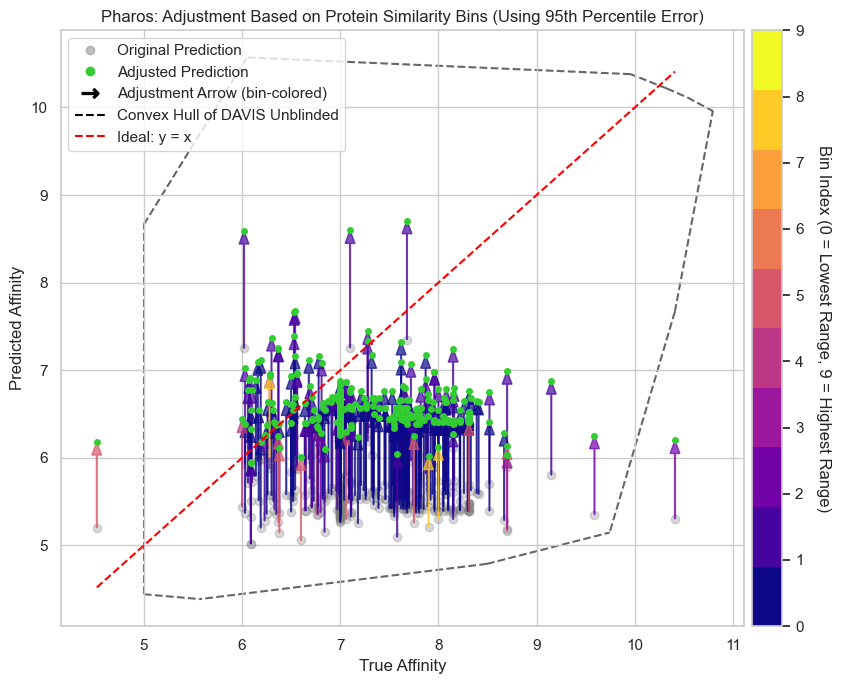

310
310
310


{'CHR': 0.0064516129032258064,
 'Mean_ERS_inside': 1.3494624663479555,
 'Mean_ERS_outside': 7.111712853002468,
 'CSVS_weighted': 1.3866382752941135,
 'CSVS_chr_scaled': 0.04588201840646753}

In [55]:
evaluate_adjustment_with_similarity_bin_coloring(
    df=pharos_df,
    unblinded = unblinded,
    true_col="True_Label",
    original_pred_col="Blinded_Prediction",
    adjusted_pred_col="Adjusted_Prediction_Protein_bin",
    error_col="Expected_Error_Protein_bin",
    bin_labels_col="Similarity_Quantile_Protein",  # make sure this column exists in pharos_df
    quantile_bins=quantile_bins,                   # this should be the same bins used for colorbar
    title="Adjustment Based on Protein Similarity Bins (Using 95th Percentile Error)",
    label_suffix=" (Protein Sim)"
)
inp = pharos_df[["True_Label","Adjusted_Prediction_Protein_bin"]].values
ERS_vals_prot, dists_blinded_prot, sparsity_weights_prot, _, is_inside_prot = compute_ERS_for_points(unblinded, inp, gamma=5.0, k=20, use_cspd=False)
compute_model_level_csvs(ERS_vals_prot,is_inside_prot)

## Drug

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pickle

# === Compute similarity of each drug to the training drugs ===
def build_drug_similarity_cache(drug_embeddings, train_drugs, save_path="drug_similarity_cache.pkl"):
    similarity_cache = {}
    train_embeddings = {
        did: drug_embeddings[did]
        for did in train_drugs if did in drug_embeddings
    }

    train_vecs = np.array(list(train_embeddings.values()))
    for did, query_vec in drug_embeddings.items():
        if did not in similarity_cache:
            if query_vec is None or train_vecs.size == 0:
                similarity_cache[did] = np.nan
            else:
                sim = cosine_similarity([query_vec], train_vecs)[0]
                similarity_cache[did] = np.mean(sim)  # or np.max(sim)

    with open(save_path, "wb") as f:
        pickle.dump(similarity_cache, f)

    # Check example IDs and values
    return similarity_cache


# === Compute similarity of each Pharos drug to DAVIS training drugs ===
def build_pharos_drug_similarity_cache(pharos_embeddings, davis_embeddings, save_path="pharos_drug_similarity_cache.pkl"):
    similarity_cache = {}
    print(f" Building similarity cache with {len(pharos_embeddings)} Pharos drugs and {len(davis_embeddings)} DAVIS drugs.")

    train_vecs = np.array(list(davis_embeddings.values()))
    for i, (did, query_vec) in enumerate(pharos_embeddings.items()):
        if query_vec is None or train_vecs.size == 0:
            similarity_cache[did] = np.nan
        else:
            sim = cosine_similarity([query_vec], train_vecs)[0]
            similarity_cache[did] = np.mean(sim)

    with open(save_path, "wb") as f:
        pickle.dump(similarity_cache, f)

    return similarity_cache

def predict_expected_error(similarity, model):
    """Predict expected 95th percentile error from similarity using trained quantile model."""
    X_new = np.column_stack([similarity, similarity**2])
    X_new = sm.add_constant(X_new, has_constant='add')
    return model.predict(X_new)

def predict_expected_error_drug_sim_quantiles(similarity_array, quantile_bins, quantile_values):
    expected_errors = []
    bin_labels = []
    for sim in similarity_array:
        for i, interval in enumerate(quantile_bins):
            if sim >= interval.left and sim <= interval.right:
                expected_errors.append(quantile_values[i])
                bin_labels.append(interval)
                break
        else:
            # Clamp to edge bin if similarity is out of range
            if sim < quantile_bins[0].left:
                expected_errors.append(quantile_values[0])
                bin_labels.append(quantile_bins[0])
            elif sim > quantile_bins[-1].right:
                expected_errors.append(quantile_values[-1])
                bin_labels.append(quantile_bins[-1])
            else:
                expected_errors.append(np.nan)
                bin_labels.append(np.nan)
    return np.array(expected_errors), bin_labels



In [57]:
train_drugs = merged_df["Drug_ID"]
drug_similarity_cache = build_drug_similarity_cache(drug_embeddings, train_drugs)

df["Drug_Similarity"] = df["Drug_ID"].map(drug_similarity_cache)

# Use qcut to assign protein similarity quantiles
df["Similarity_Quantile_Drug"] = pd.qcut(df["Drug_Similarity"], q=10, duplicates='drop')

# Group by quantile and compute mean error in each
#quantile_error_lookup_drug = df.groupby("Similarity_Quantile_Drug")["Percent_Error"].mean()
quantile_error_lookup_drug = df.groupby("Similarity_Quantile_Drug")["Percent_Error"].quantile(0.95)

quantile_bins_drug = df["Similarity_Quantile_Drug"].cat.categories  # stores interval bounds

# Fit quadratic quantile regression
X = df["Drug_Similarity"]
y = df["Percent_Error"]
X_poly = sm.add_constant(np.column_stack([X, X**2]))
model = sm.QuantReg(y, X_poly).fit(q=0.95)

/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_54511/334693585.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantile_error_lookup_drug = df.groupby("Similarity_Quantile_Drug")["Percent_Error"].quantile(0.95)
/opt/anaconda3/envs/geometric/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


In [58]:
# === 1. Build similarity cache and compute similarity values
pharos_sim_cache_drug = build_pharos_drug_similarity_cache(
    pharos_drug_embeddings, davis_drug_embeddings
)
pharos_df["Drug_Similarity"] = pharos_df["Drug_ID"].map(pharos_sim_cache_drug)

# === 2. Predict continuous expected error using quantile regression model
pharos_df["Expected_Error_Drug"] = predict_expected_error(pharos_df["Drug_Similarity"].values, model)
pharos_df["Adjusted_Prediction_Drug"] = pharos_df["Blinded_Prediction"] * (1 + pharos_df["Expected_Error_Drug"] / 100)

# === 3. Adjust bins to ensure Pharos values fall within quantile intervals
# Extract bin edges from quantile_bins_drug
bin_edges = sorted(set([b.left for b in quantile_bins_drug] + [quantile_bins_drug[-1].right]))

# Extend bin edges if necessary
min_sim = pharos_df["Drug_Similarity"].min()
max_sim = pharos_df["Drug_Similarity"].max()
if min_sim < bin_edges[0]:
    bin_edges[0] = min_sim - 1e-6
if max_sim > bin_edges[-1]:
    bin_edges[-1] = max_sim + 1e-6

# Assign bin labels
pharos_df["Drug_Similarity_Bin_Label"] = pd.cut(
    pharos_df["Drug_Similarity"],
    bins=bin_edges,
    labels=quantile_bins_drug,
    include_lowest=True
)

# Map binned expected errors
bin_label_to_error = dict(zip(quantile_bins_drug, quantile_error_lookup_drug.values))
pharos_df["Expected_Error_Drug_bin"] = pharos_df["Drug_Similarity_Bin_Label"].map(bin_label_to_error).astype(float)
pharos_df["Adjusted_Prediction_Drug_bin"] = pharos_df["Blinded_Prediction"] * (1 + pharos_df["Expected_Error_Drug_bin"] / 100)

# === 4. Report counts
print("\n Expected % Error by Drug Similarity Quantile:")
print(f"{'Bin Range':<25} {'% Error':<10} {'Pharos Points':<15}")
print("-" * 60)
for bin_label in quantile_bins_drug:
    err = quantile_error_lookup_drug[bin_label]
    count = (pharos_df["Drug_Similarity_Bin_Label"] == bin_label).sum()
    print(f"{str(bin_label):<25} {err:<10.2f} {count:<15}")


 Building similarity cache with 209 Pharos drugs and 68 DAVIS drugs.

 Expected % Error by Drug Similarity Quantile:
Bin Range                 % Error    Pharos Points  
------------------------------------------------------------
(0.947, 0.959]            16.12      116            
(0.959, 0.964]            17.03      68             
(0.964, 0.966]            13.61      24             
(0.966, 0.969]            16.47      33             
(0.969, 0.97]             16.00      14             
(0.97, 0.972]             15.98      18             
(0.972, 0.973]            20.81      6              
(0.973, 0.975]            16.20      13             
(0.975, 0.977]            18.66      12             
(0.977, 0.979]            18.03      6              


 Original Predictions (Drug Sim):
   MSE = 3.523
   MAE  = 1.725

 Adjusted Predictions (+Expected % Error) (Drug Sim):
   MSE = 1.282
   MAE  = 0.945
Improved Points: 291 / 310


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_54511/395044131.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma", n_bins)


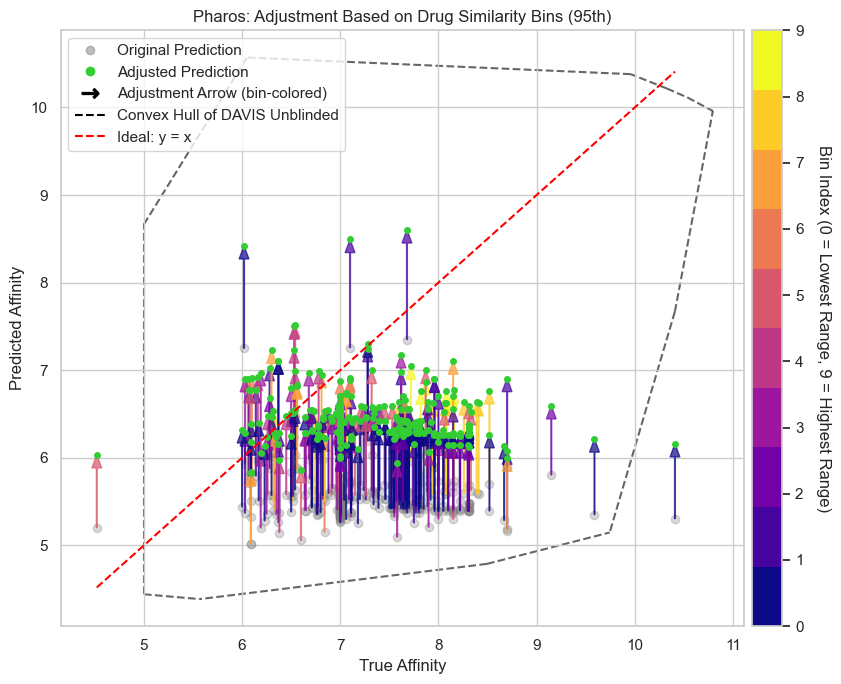

310
310
310


{'CHR': 0.0064516129032258064,
 'Mean_ERS_inside': 1.4919256051939234,
 'Mean_ERS_outside': 7.129586786558232,
 'CSVS_weighted': 1.5282976128156287,
 'CSVS_chr_scaled': 0.0459973341068273}

In [59]:
evaluate_adjustment_with_similarity_bin_coloring(
    df=pharos_df,
    unblinded = unblinded,
    true_col="True_Label",
    original_pred_col="Blinded_Prediction",
    adjusted_pred_col="Adjusted_Prediction_Drug_bin",
    error_col="Expected_Error_Drug_bin",
    bin_labels_col="Drug_Similarity_Bin_Label",
    quantile_bins=quantile_bins_drug,
    title="Adjustment Based on Drug Similarity Bins (95th)",
    label_suffix=" (Drug Sim)"
)
ind = pharos_df[["True_Label","Adjusted_Prediction_Drug_bin"]].values
ERS_vals_drug, _, _, _, is_inside_drug = compute_ERS_for_points(unblinded, ind, gamma=5.0, k=20, use_cspd=False)
compute_model_level_csvs(ERS_vals_drug,is_inside_drug)

## Affinity

In [60]:
# 1. Define bins
affinity_bins = [4, 5, 6, 7, 8, 9, 10]
pharos_df["Affinity_Bin"] = pd.cut(pharos_df["Blinded_Prediction"], bins=affinity_bins)

# 2. Compute mean signed error per bin on DAVIS
bin_means = (
    df
    .assign(Affinity_Bin=pd.cut(df["Blinded_Prediction"], bins=affinity_bins))
    .groupby("Affinity_Bin")["Percent_Error"]
    .quantile(0.95)
)

# 3. Apply correction
pharos_df["Bin_Correction"] = pharos_df["Affinity_Bin"].map(bin_means).astype(float)

# 4. Adjust prediction
pharos_df["Bin_Adjusted"] = pharos_df["Blinded_Prediction"] * (1 + pharos_df["Bin_Correction"] / 100)

# 5. Optional evaluation
if "True_Label" in pharos_df:
    true = pharos_df["True_Label"]
    original = pharos_df["Blinded_Prediction"]
    adjusted = pharos_df["Bin_Adjusted"]
    
    rmse_orig = np.sqrt(mean_squared_error(true, original))
    mae_orig = mean_absolute_error(true, original)
    rmse_adj = np.sqrt(mean_squared_error(true, adjusted))
    mae_adj = mean_absolute_error(true, adjusted)
    
    print(f" Original Prediction:  RMSE={rmse_orig:.3f}, MAE={mae_orig:.3f}")
    print(f"Bin-Adjusted Prediction:  RMSE={rmse_adj:.3f}, MAE={mae_adj:.3f}")


print("\n Expected % Error by Predicted Affinity Bin:")
print(f"{'Bin Range':<15} {'% Error':<10} {'Pharos Points':<15}")
print("-" * 45)

# Reuse the same bins and bin_means used earlier
for bin_label in bin_means.index:
    err = bin_means[bin_label]
    count = (pharos_df["Affinity_Bin"] == bin_label).sum()
    print(f"{str(bin_label):<15} {err:<10.2f} {count:<15}")


 Original Prediction:  RMSE=1.877, MAE=1.725
Bin-Adjusted Prediction:  RMSE=1.186, MAE=1.000

 Expected % Error by Predicted Affinity Bin:
Bin Range       % Error    Pharos Points  
---------------------------------------------
(4, 5]          10.54      0              
(5, 6]          15.47      292            
(6, 7]          22.69      15             
(7, 8]          28.49      3              
(8, 9]          34.25      0              
(9, 10]         38.86      0              


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_54511/3440035828.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Affinity_Bin")["Percent_Error"]


 Original Predictions (Affinity):
   MSE = 3.523
   MAE  = 1.725

 Adjusted Predictions (+Expected % Error) (Affinity):
   MSE = 1.406
   MAE  = 1.000
Improved Points: 289 / 310


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_54511/395044131.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma", n_bins)


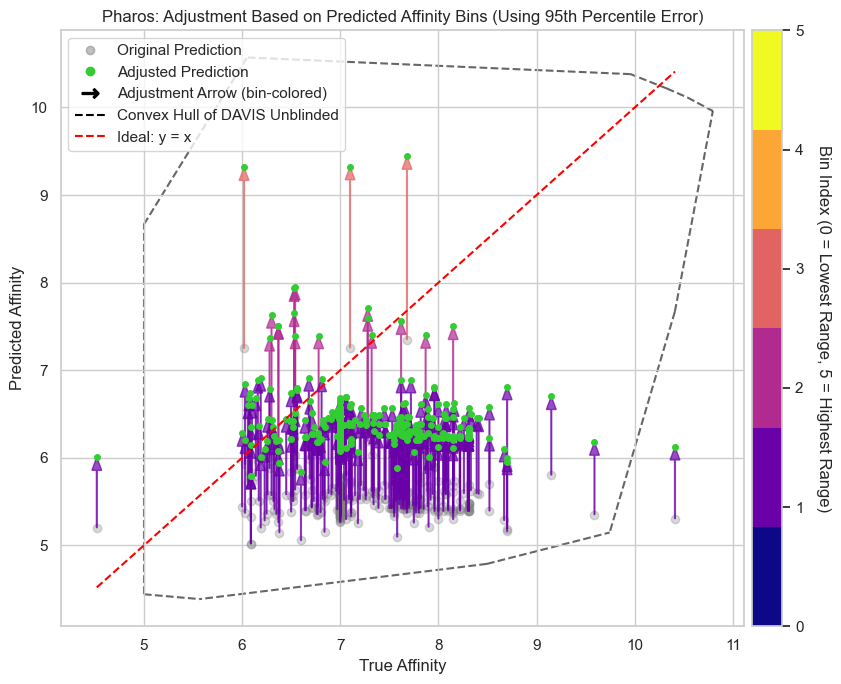

310
310
310


{'CHR': 0.0064516129032258064,
 'Mean_ERS_inside': 1.5584152762816172,
 'Mean_ERS_outside': 7.145538880894384,
 'CSVS_weighted': 1.5944612350210543,
 'CSVS_chr_scaled': 0.0461002508444799}

In [61]:
pharos_df["Affinity_Bin_Label"] = pd.cut(
    pharos_df["Blinded_Prediction"],
    bins=[b.left for b in bin_means.index] + [bin_means.index[-1].right],
    labels=bin_means.index,
    include_lowest=True
)

# 7. Plot results
evaluate_adjustment_with_similarity_bin_coloring(
    df=pharos_df,
    unblinded = unblinded,
    true_col="True_Label",
    original_pred_col="Blinded_Prediction",
    adjusted_pred_col="Bin_Adjusted",
    error_col="Bin_Correction",
    bin_labels_col="Affinity_Bin_Label",
    quantile_bins=bin_means.index,
    title="Adjustment Based on Predicted Affinity Bins (Using 95th Percentile Error)",
    label_suffix=" (Affinity)"
)
ina = pharos_df[["True_Label","Bin_Adjusted"]].values
ERS_vals_aff, _, _, _, is_inside_aff = compute_ERS_for_points(unblinded, ina, gamma=5.0, k=20, use_cspd=False)
compute_model_level_csvs(ERS_vals_aff,is_inside_aff)

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points
from scipy.spatial import Delaunay, ConvexHull
from sklearn.neighbors import NearestNeighbors

# === Load and merge data ===
unblinded_df = pd.read_csv("new/AVG_crossval_predictions.csv")
blinded_df = pd.read_csv("new/concatenated_final_test_predictions.csv")
pharos_df=pd.read_csv("new/AVG_pharos_test_predictions.csv")

unblinded_df = unblinded_df.rename(columns={"Predicted_Value": "Unblinded_Prediction"})
blinded_df = blinded_df.rename(columns={"Predicted_Value": "Blinded_Prediction"})
pharos_df = pharos_df.rename(columns={"Predicted_Value": "Blinded_Prediction"})
blinded_df["Drug_ID"] = blinded_df["Drug_ID"].astype(str)
unblinded_df["Drug_ID"] = unblinded_df["Drug_ID"].astype(str)

merged_df = pd.merge(
    unblinded_df[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction"]],
    blinded_df[["Drug_ID", "Protein_ID", "True_Label", "Blinded_Prediction"]],
    on=["Drug_ID", "Protein_ID", "True_Label"]
)

unblinded = merged_df[["True_Label", "Unblinded_Prediction"]].values
blinded = merged_df[["True_Label", "Blinded_Prediction"]].values
pharos = pharos_df[["True_Label", "Blinded_Prediction"]].values

# === 2. Identify unmatched ===
unblinded_unmatched = pd.merge(
    unblinded_df, merged_df[["Drug_ID", "Protein_ID", "True_Label"]],
    on=["Drug_ID", "Protein_ID", "True_Label"],
    how="left", indicator=True
).query('_merge == "left_only"').drop(columns=["_merge"])

blinded_unmatched = pd.merge(
    blinded_df, merged_df[["Drug_ID", "Protein_ID", "True_Label"]],
    on=["Drug_ID", "Protein_ID", "True_Label"],
    how="left", indicator=True
).query('_merge == "left_only"').drop(columns=["_merge"])

print(f" Unmatched in unblinded: {len(unblinded_unmatched)}")
print(f" Unmatched in blinded: {len(blinded_unmatched)}")

# === 3. Iterative matching by rounding True_Label ===
merged_rounded = pd.DataFrame()

for r in [8,7,6,5,4]:
    print(f"\n Trying merge with True_Label rounded to {r} decimals...")
    u = unblinded_unmatched.copy()
    b = blinded_unmatched.copy()

    u["Rounded_Label"] = u["True_Label"].round(r)
    b["Rounded_Label"] = b["True_Label"].round(r)

    merged = pd.merge(
        u[["Drug_ID", "Protein_ID", "Rounded_Label", "True_Label", "Unblinded_Prediction"]],
        b[["Drug_ID", "Protein_ID", "Rounded_Label", "True_Label", "Blinded_Prediction"]],
        on=["Drug_ID", "Protein_ID", "Rounded_Label"],
        suffixes=("_unblinded", "_blinded"),
        how="inner"
    )

    print(f" Matched {len(merged)} more rows at {r} decimals")
    merged_rounded = pd.concat([merged_rounded, merged], ignore_index=True)

    # Update unmatched
    matched_keys = merged[["Drug_ID", "Protein_ID", "Rounded_Label"]].drop_duplicates()
    unblinded_unmatched = pd.merge(u, matched_keys, on=["Drug_ID", "Protein_ID", "Rounded_Label"], how="left", indicator=True)
    unblinded_unmatched = unblinded_unmatched.query('_merge == "left_only"').drop(columns=["_merge"])

    blinded_unmatched = pd.merge(b, matched_keys, on=["Drug_ID", "Protein_ID", "Rounded_Label"], how="left", indicator=True)
    blinded_unmatched = blinded_unmatched.query('_merge == "left_only"').drop(columns=["_merge"])

# === 4. Combine all matched ===
all_merged = pd.concat([
    merged_df[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction", "Blinded_Prediction"]],
    merged_rounded[["Drug_ID", "Protein_ID", "True_Label_blinded", "Unblinded_Prediction", "Blinded_Prediction"]].rename(columns={"True_Label_blinded": "True_Label"})
], ignore_index=True)

print(f"\n Total merged: {len(all_merged)}")
print(f" Still unmatched in blinded: {len(blinded_unmatched)}")
print(f" Still unmatched in unblinded: {len(unblinded_unmatched)}")

# Save final datasets if desired
all_merged.to_csv("merged_blinded_unblinded_full.csv", index=False)
blinded_unmatched.to_csv("unmatched_blinded_rows.csv", index=False)

# After iterative merge, use all_merged as your gold-standard matched data
unblinded_df = all_merged[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction"]].copy()
blinded_df   = all_merged[["Drug_ID", "Protein_ID", "True_Label", "Blinded_Prediction"]].copy()
merged_df = all_merged

# Redefine your arrays to use only the merged data
unblinded = all_merged[["True_Label", "Unblinded_Prediction"]].values
blinded   = all_merged[["True_Label", "Blinded_Prediction"]].values

# Leave pharos as-is (it's already separate and untouched)
pharos    = pharos_df[["True_Label", "Blinded_Prediction"]].values

print(len(blinded_df))
print(len(unblinded_df))
print(len(blinded))
print(len(unblinded))


_,is_inside = compute_continuous_hull_distance(unblinded, blinded)
blinded_df["Is_Inside"] = is_inside

outside_mask = ~blinded_df["Is_Inside"]
#THIS LINE CONTROLS IF ONLY OUTSIDE DATA IS USED FOR TRAINING THE MODEL!!!!
#merged_df = merged_df[outside_mask]

 Unmatched in unblinded: 9508
 Unmatched in blinded: 3697

 Trying merge with True_Label rounded to 8 decimals...
 Matched 643 more rows at 8 decimals

 Trying merge with True_Label rounded to 7 decimals...
 Matched 544 more rows at 7 decimals

 Trying merge with True_Label rounded to 6 decimals...
 Matched 2105 more rows at 6 decimals

 Trying merge with True_Label rounded to 5 decimals...
 Matched 405 more rows at 5 decimals

 Trying merge with True_Label rounded to 4 decimals...
 Matched 0 more rows at 4 decimals

 Total merged: 27621
 Still unmatched in blinded: 0
 Still unmatched in unblinded: 5811
27621
27621
27621
27621


# MODEL BASED ERR PRED

In [44]:
# MODEL BASED ERR PRED
import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.inspection import permutation_importance

# === Percent Error Target ===
merged_df["Signed_Percent_Error"] = (
    100 * (merged_df["Unblinded_Prediction"] - merged_df["Blinded_Prediction"]) / merged_df["True_Label"]
)
print(merged_df["Signed_Percent_Error"].describe())


# === Filter for available embeddings ===
davis_merged = merged_df[
    merged_df["Drug_ID"].isin(davis_drug_embeddings) &
    merged_df["Protein_ID"].isin(davis_protein_embeddings)
].copy()

# === Similarity Feature Function ===
def compute_similarity_features(df, drug_embs, prot_embs, train_drug_embs, train_prot_embs):
    ref_drug_vecs = np.stack(list(train_drug_embs.values()))
    ref_prot_vecs = np.stack(list(train_prot_embs.values()))
    features = []
    for _, row in df.iterrows():
        did, pid = row["Drug_ID"], row["Protein_ID"]
        if did not in drug_embs or pid not in prot_embs:
            features.append([np.nan] * 4)
            continue
        drug_sim = cosine_similarity([drug_embs[did]], ref_drug_vecs)[0]
        prot_sim = cosine_similarity([prot_embs[pid]], ref_prot_vecs)[0]
        features.append([
            np.mean(drug_sim), np.max(drug_sim),
            np.mean(prot_sim), np.max(prot_sim)
        ])
    return pd.DataFrame(features, columns=[
        "Drug_Sim_Mean", "Drug_Sim_Max", "Prot_Sim_Mean", "Prot_Sim_Max"
    ])

# === Compute similarity features ===
sim_feats = compute_similarity_features(
    davis_merged,
    drug_embs=davis_drug_embeddings,
    prot_embs=davis_protein_embeddings,
    train_drug_embs=davis_drug_embeddings,
    train_prot_embs=davis_protein_embeddings
)
davis_merged = pd.concat([davis_merged.reset_index(drop=True), sim_feats.reset_index(drop=True)], axis=1)

# === Extra Features ===
min_davis_unblinded = davis_merged["Unblinded_Prediction"].min()
davis_merged["Below_Train_Min"] = (davis_merged["Blinded_Prediction"] < min_davis_unblinded).astype(int)
davis_merged["Confidence_Proxy"] = davis_merged["Drug_Sim_Mean"] * davis_merged["Prot_Sim_Mean"]

# === Model training data ===
X_train = davis_merged[[
    "Blinded_Prediction", "Drug_Sim_Mean", "Drug_Sim_Max",
    "Prot_Sim_Mean", "Prot_Sim_Max", "Confidence_Proxy"
]]
y_train = davis_merged["Signed_Percent_Error"]


reg = HistGradientBoostingRegressor(max_iter=300, random_state=42)
reg.fit(X_train, y_train)

# === Interpret model (optional) ===
perm_importances = permutation_importance(reg, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1)
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": perm_importances.importances_mean,
    "Std": perm_importances.importances_std
}).sort_values(by="Importance", ascending=False)
print(importance_df)



# === Prepare Pharos features ===
pharos_sim_feats = compute_similarity_features(
    pharos_df,
    drug_embs=pharos_drug_embeddings,
    prot_embs=pharos_protein_embeddings,
    train_drug_embs=davis_drug_embeddings,
    train_prot_embs=davis_protein_embeddings
)
pharos_df_sim = pd.concat([pharos_df.reset_index(drop=True), pharos_sim_feats], axis=1)

pharos_df_sim["Confidence_Proxy"] = (
    pharos_df_sim["Drug_Sim_Mean"] * pharos_df_sim["Prot_Sim_Mean"]
)

X_pharos = pharos_df_sim[[
    "Blinded_Prediction", "Drug_Sim_Mean", "Drug_Sim_Max",
    "Prot_Sim_Mean", "Prot_Sim_Max", "Confidence_Proxy"
]]

# === Predict % Error ===
pharos_df_sim["Predicted_Signed_Percent_Error"] = reg.predict(X_pharos)
pharos_df_sim["Adjusted_Prediction"] = pharos_df_sim["Blinded_Prediction"] * (
    1 + pharos_df_sim["Predicted_Signed_Percent_Error"] / 100
)

print(pharos_df_sim["Predicted_Signed_Percent_Error"].describe())
print(pharos_df_sim["Adjusted_Prediction"].describe())

inm = pharos_df_sim[["True_Label","Adjusted_Prediction"]].values
ERS_vals_mod, _, _, _, is_inside_mod = compute_ERS_for_points(unblinded, inm, gamma=5.0, k=20, use_cspd=False)
compute_model_level_csvs(ERS_vals_mod,is_inside_mod)

count    27621.000000
mean         0.541577
std          7.727186
min        -68.246427
25%         -1.922145
50%          0.430646
75%          3.154325
max         55.512991
Name: Signed_Percent_Error, dtype: float64
              Feature  Importance       Std
0  Blinded_Prediction    0.721675  0.008224
3       Prot_Sim_Mean    0.427969  0.006461
4        Prot_Sim_Max    0.194547  0.004082
1       Drug_Sim_Mean    0.166521  0.003068
5    Confidence_Proxy    0.116066  0.002422
2        Drug_Sim_Max    0.044280  0.001982
count    310.000000
mean      -2.792247
std        3.781244
min      -16.953046
25%       -4.659638
50%       -2.921915
75%       -0.737317
max       12.103459
Name: Predicted_Signed_Percent_Error, dtype: float64
count    310.000000
mean       5.395541
std        0.219497
min        4.986909
25%        5.231632
50%        5.362746
75%        5.514486
max        6.232956
Name: Adjusted_Prediction, dtype: float64
310
310
310


{'CHR': 0.0064516129032258064,
 'Mean_ERS_inside': 3.2327214601786425,
 'Mean_ERS_outside': 7.456090348841025,
 'CSVS_weighted': 3.259969001395819,
 'CSVS_chr_scaled': 0.048103808702200164}

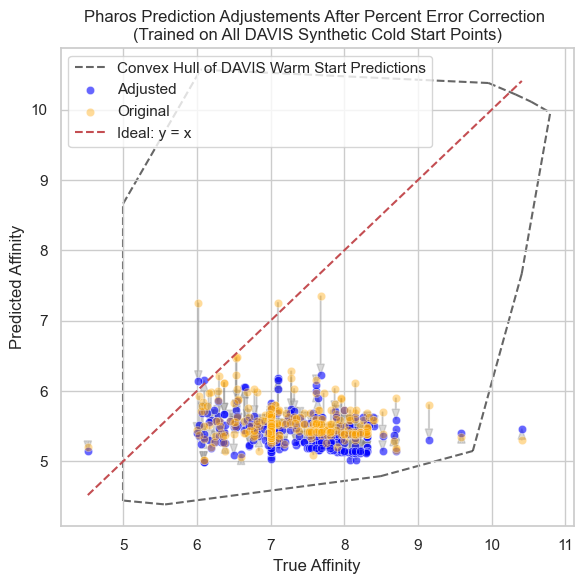

Original MSE: 3.5226387539001296
Adjusted MSE: 4.078924691753762
Original MAE: 1.7250456939205046
Adjusted MAE: 1.8779041923166437


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))

# === Convex Hull of Original Predictions ===
# Construct 2D array of (True_Label, Blinded_Prediction)
points = unblinded
plotted_hull = False  # Flag to avoid adding multiple legend entries
if len(points) >= 3:
    try:
        hull = ConvexHull(points)
        for i, simplex in enumerate(hull.simplices):
            # Add label only to the first segment to show in the legend
            label = "Convex Hull of DAVIS Warm Start Predictions" if not plotted_hull else None
            plt.plot(
                points[simplex, 0], points[simplex, 1],
                color='black', linestyle='--', linewidth=1.5, alpha=0.6, zorder=0, label=label
            )
            plotted_hull = True
    except Exception as e:
        print(f"Warning: Could not compute convex hull — {e}")

# Plot arrows: original → adjusted
for _, row in pharos_df_sim.iterrows():
    plt.arrow(
        row["True_Label"], row["Blinded_Prediction"],
        0, row["Adjusted_Prediction"] - row["Blinded_Prediction"],
        color='gray', alpha=0.3, width=0.01, head_width=0.1, length_includes_head=True
    )

# Scatter adjusted points
sns.scatterplot(
    x=pharos_df_sim["True_Label"],
    y=pharos_df_sim["Adjusted_Prediction"],
    color="blue", label="Adjusted", alpha=0.6
)

# Scatter original predictions
sns.scatterplot(
    x=pharos_df_sim["True_Label"],
    y=pharos_df_sim["Blinded_Prediction"],
    color="orange", label="Original", alpha=0.4
)

# y = x line
lims = [
    min(pharos_df_sim["True_Label"].min(), pharos_df_sim["Blinded_Prediction"].min(), pharos_df_sim["Adjusted_Prediction"].min()),
    max(pharos_df_sim["True_Label"].max(), pharos_df_sim["Blinded_Prediction"].max(), pharos_df_sim["Adjusted_Prediction"].max())
]
plt.plot(lims, lims, 'r--', label='Ideal: y = x')

plt.xlabel("True Affinity")
plt.ylabel("Predicted Affinity")
plt.title("Pharos Prediction Adjustements After Percent Error Correction \n(Trained on All DAVIS Synthetic Cold Start Points)")
plt.legend()
plt.tight_layout()
plt.show()

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

true = pharos_df_sim["True_Label"]
orig = pharos_df_sim["Blinded_Prediction"]
adj = pharos_df_sim["Adjusted_Prediction"]

print("Original MSE:", mean_squared_error(true, orig))
print("Adjusted MSE:", mean_squared_error(true, adj))
print("Original MAE:", (mean_absolute_error(true, orig)))
print("Adjusted MAE:", (mean_absolute_error(true, adj)))

Outside Only: 

              Feature  Importance  Std
0  Blinded_Prediction         0.0  0.0
1       Drug_Sim_Mean         0.0  0.0
2        Drug_Sim_Max         0.0  0.0
3       Prot_Sim_Mean         0.0  0.0
4        Prot_Sim_Max         0.0  0.0
5    Confidence_Proxy         0.0  0.0
count    310.000000
mean       8.549338
std        0.000000
min        8.549338
25%        8.549338
50%        8.549338
75%        8.549338
max        8.549338
Name: Predicted_Signed_Percent_Error, dtype: float64
count    310.000000
mean       6.031729
std        0.302212
min        5.446567
25%        5.869668
50%        5.974090
75%        6.104946
max        7.978985
Name: Adjusted_Prediction, dtype: float64

Original MSE: 3.5226387539001296
Adjusted MSE: 2.1396957722370122
Original MAE: 1.7250456939205046
Adjusted MAE: 1.2915912119202646

{'CHR': 0.0064516129032258064,
 'Mean_ERS_inside': 2.0847200321957526,
 'Mean_ERS_outside': 7.316167506760018,
 'CSVS_weighted': 2.1184713062251994,
 'CSVS_chr_scaled': 0.04720108068877431}

Inside and Outside

              Feature  Importance       Std
0  Blinded_Prediction    0.798994  0.006849
3       Prot_Sim_Mean    0.466850  0.005329
4        Prot_Sim_Max    0.216770  0.005268
1       Drug_Sim_Mean    0.209261  0.002669
5    Confidence_Proxy    0.140892  0.002201
2        Drug_Sim_Max    0.052135  0.002416
count    310.000000
mean      -3.081884
std        3.821206
min      -12.796510
25%       -6.110210
50%       -3.327121
75%       -0.662676
max        8.156381
Name: Predicted_Signed_Percent_Error, dtype: float64
count    310.000000
mean       5.381902
std        0.276641
min        4.995417
25%        5.160286
50%        5.373327
75%        5.529135
max        6.845660
Name: Adjusted_Prediction, dtype: float64

Original MSE: 3.5226387539001296
Adjusted MSE: 4.1779426616876005
Original MAE: 1.7250456939205046
Adjusted MAE: 1.897319600733681

{'CHR': 0.0064516129032258064,
 'Mean_ERS_inside': 3.510191122411653,
 'Mean_ERS_outside': 7.56000057479198,
 'CSVS_weighted': 3.5363189253302356,
 'CSVS_chr_scaled': 0.04877419725672245}